In [1]:
import numpy as np
import scipy as sp
import scipy.io as sio

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import tqdm

import scipy.io

from sklearn.decomposition import PCA


C:\Users\vladka\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# original dataset pixels have values in [-1, 1]
# so we need to scale it to use sigmoid in our NN
def normalize(batch):
    batch = batch - np.mean(batch)
    
    pstd = 3*batch.std()
    
    batch[batch >= pstd] = pstd
    batch[batch <= -pstd] = -pstd;
    
    batch /= pstd
    
    batch = (batch+1)*0.4 + 0.1
    
    return batch

In [53]:
def pair_generator(lst):
    for p, n in zip(lst[:-1], lst[1:]):
        yield (p, n)

In [218]:
# fully connected layer
# tensor - previous tensor
# w_size - size of the weight matrix, smth like (input size, output size)
# b_size - size of the bias vector, smth like (output_size,)
# name - name of the layer
# activation - activation function, smth like tf.nn.sigmoid
#              for this project we will use sigmoid functions because we want to use KL loss for sparsity 

def create_fc_layer(tensor, w_size, b_size, name, activation):
    r = np.sqrt(6) / np.sqrt(w_size[0] + w_size[1] + 1)

    W = tf.Variable(tf.random_uniform(w_size, minval=-r, maxval=r, dtype=tf.float32), name=name + '.w')
    b = tf.Variable(tf.constant(0., shape=(b_size,), dtype=tf.float32), name=name + 'bias')

    return W, activation(tf.matmul(tensor, W) + b)

# class to represent sparse autoencoder. Trying to give it sklearn-like interface
# num_input - size of the input vector
# num_hidden - size of the hidden layer (only one at this moment)
# max_iters - number of iterations for cost function optimization (only for scipy interface)
# optimizer - optimizer class from tf.train (smth like tf.train.AdamOptimizer)
# lr - learning rate
# beta - coefficient for KL sparse loss
# prob - target probability for activation
# weight_lambda - coefficient for weight regularization
# optim_type = type of optimization, if equals to 'scipy' scipy interface called (for natural images better)
#              otherwise use 'gradient' with optimizer

class SparseAutoencoder(object):
    def __init__(self, num_input, num_hidden, optimizer=tf.train.AdamOptimizer, lr=0.01, keep_prob=0.5,
                 beta=3., prob=0.01, weight_lambda=0.0001, act_lambda = 0.001):
        self.num_input = num_input
        self.num_hidden = num_hidden
        self.beta = beta
        self.weight_lambda = weight_lambda
        self.act_lambda = act_lambda
        self.sparsity_level = prob
        self.keep_prob = keep_prob
       
        self.x = tf.placeholder(tf.float32, [None, self.num_input])
        
        self.enc_layers = list()
        self.enc_weights = list()
        
        prev_tensor = self.x
        for prev, next in pair_generator([num_input] + list(num_hidden)):
            print(prev, next)
            [curr_weights, curr_layer] = create_fc_layer(prev_tensor, (prev, next), next,
                                                         name='encoder_{}_{}'.format(prev, next), activation=tf.nn.sigmoid)
            curr_dropout = tf.nn.dropout(curr_layer, self.keep_prob)
            prev_tensor = curr_dropout
            
            self.enc_layers.append(curr_layer)
            self.enc_weights.append(curr_weights)

        [self.dec_weights, self.reconstruction] = create_fc_layer(prev_tensor, (num_hidden[~0], self.num_input),
                                                                  self.num_input, name='decoder',
                                                                  activation=tf.nn.sigmoid)
        
        self.cost = self.get_sparse_loss()
        self.optimizer = optimizer(learning_rate=lr).minimize(self.cost)

        init = tf.global_variables_initializer()
        self.session = tf.Session()
        self.session.run(init)

    def fit(self, X):
        # dirty! refactor it.
        cost, opt = self.session.run((self.cost, self.optimizer), feed_dict = {self.x: X})
        return cost
    
    def get_sparse_loss(self):
        subj_mse = tf.reduce_sum(tf.pow(self.x - self.reconstruction, 2), axis=1)
        self.mse_loss = 0.5 * tf.reduce_mean(subj_mse)
        
        kl_losses = list()
        # sparsity for activation using KL divergence
        for idx, layer in enumerate(self.enc_layers):
            p_hat = tf.reduce_mean(layer, axis=0)
            left = self.sparsity_level[idx] * tf.log(self.sparsity_level[idx] / p_hat)
            right = (1 - self.sparsity_level[idx]) * tf.log((1 - self.sparsity_level[idx]) / (1 - p_hat))
            kl_losses.append(tf.reduce_sum(left + right))
        
        self.kl_loss = self.beta*tf.reduce_sum(kl_losses)

        reg_losses = list()
        for layer in self.enc_weights + [self.dec_weights]:
            reg_losses.append(tf.nn.l2_loss(layer))
        
        self.reg_loss = self.weight_lambda*tf.reduce_sum(reg_losses)
        
        # sparsity for activation using l1 loss
        self.sp_loss = self.act_lambda * tf.reduce_sum([tf.reduce_sum(layer) for layer in self.enc_layers])
        
        return self.mse_loss + self.reg_loss + self.sp_loss + self.kl_loss

    def calculate_total_cost(self, X):
        return self.session.run(self.cost, feed_dict={self.x: X})

    def calc_mse_loss(self, X):
        return self.session.run(self.mse_loss, feed_dict={self.x: X})

    def calc_kl_loss(self, X):
        return self.session.run(self.kl_loss, feed_dict={self.x: X})
    
    def encode(self, X):
        return self.session.run(self.hidden_layer, feed_dict={self.x: X})

    def reconstruct(self, X):
        return self.session.run(self.reconstruction, feed_dict={self.x: X})

    def get_weights(self):
        return self.session.run(self.enc_weights)

In [330]:
m = SparseAutoencoder(28*28, [64, 36], prob=[4./64, 2./36], weight_lambda=0.00075, act_lambda=0.00005, beta=3, lr=0.01, keep_prob=0.9)

784 64
64 36


In [331]:
cost_hist = list()

for _ in tqdm.tnrange(5000):
    mnist_batch, _ = mnist.train.next_batch(256)
#     mnist_batch = normalize(mnist_batch)
    loss = m.fit(mnist_batch)
    cost_hist.append(loss)

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

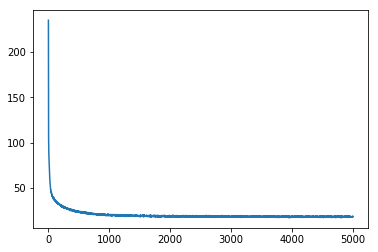

In [332]:
plt.plot(cost_hist)

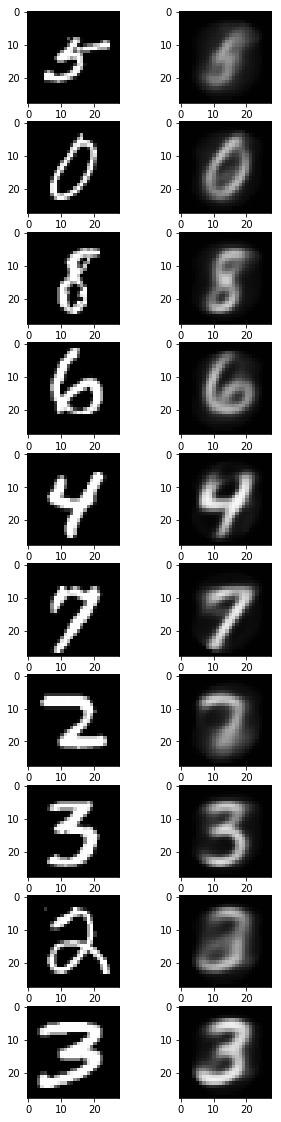

In [333]:
res = m.reconstruct(mnist_batch[:10])
fig, axes = plt.subplots(10, 2, figsize=(5,20))

for orig, rec, ax in zip(mnist_batch[:10], res, axes):
    ax[0].imshow(orig.reshape((28,28)), cmap='gray', vmin=0, vmax=1)
    ax[1].imshow(rec.reshape((28,28)), cmap='gray', vmin=0, vmax=1)

In [334]:
w1, w2 = m.get_weights()

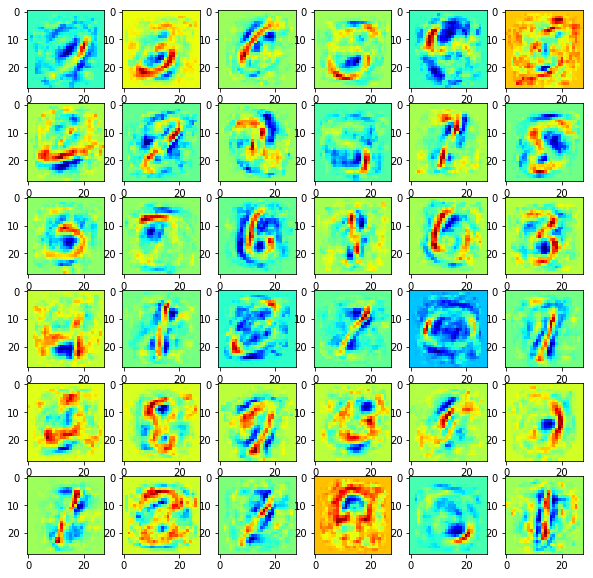

In [335]:
fig, axes = plt.subplots(6, 6, figsize=(10,10))

for ax, img in zip(axes.flatten(), w1.T):
    ax.imshow(img.reshape((28, 28)), cmap='jet')

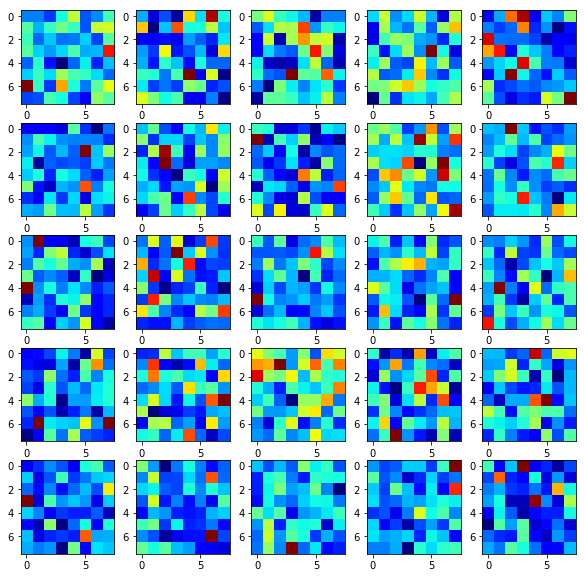

In [329]:
fig, axes = plt.subplots(5, 5, figsize=(10,10))

for ax, img in zip(axes.flatten(), w2.T):
    ax.imshow(img.reshape((8, 8)), cmap='jet')